# 3. Quantum Teleportation and Superdense Coding

Kifumi Numata (Apr 26, 2024)

Approximate QPU time to run this experiment is 10 seconds.

Click [here](https://learning-api.quantum.ibm.com/assets/27de85b5-8781-427e-a86a-4d2c27b2e591) to download this notebook in Jupyter format.

Click [here](https://learning-api.quantum.ibm.com/assets/cfe33bea-efa0-4fd6-a8dd-db1218f4ec84) to download the pdf of the original lecture. Please note that some code snippets may become deprecated since these are static images.

## 1. Introduction

To solve any utility scale quantum problem, we will need to move information around on a quantum computer from one qubit to another. There are well-known protocols for doing this, but some of the most foundational were cast in the context of sending information between distant parties. Throughout this lesson, we will sometimes use language consistent with this context, such as "distant friends sending information". But keep in mind that these protocols have broader significance in quantum computing. In this lesson we consider the following quantum communication protocols:
- **Quantum teleportation**
    Using a shared entangled state (sometimes called an e-bit) to send an unknown quantum state to a distant friend, requiring supplemental classical communication.
- **Quantum superdense coding**
    How to send 2 bits of information by sending a single qubit to a distant friend (again using prior shared entangled qubits).

For more background relevant to these topics, we recommend lesson 4 in Basics of Quantum Information on [Entanglement in Action](https://learning.quantum.ibm.com/course/basics-of-quantum-information/entanglement-in-action).

In the above description, an "unknown quantum state" simply refers to a state of the form described in the previous lesson:
$$
|\psi\rangle =\alpha|0\rangle+\beta|1\rangle
$$
where $\alpha$ and $\beta$ are complex numbers such that $|\alpha|^2+|\beta|^2 = 1$.  This allows us to write the quantum state as
$$
|\psi\rangle =\cos\frac{\theta}{2}|0\rangle+e^{i\varphi}\sin\frac{\theta}{2}|1\rangle=
\left(
\begin{matrix}
\cos\frac{\theta}{2}\\
e^{i\varphi}\sin\frac{\theta}{2}
\end{matrix}
\right)
$$
Since we want to be able to transfer the information in any random quantum state, generating such a state is where we will begin this lesson.

## 2. Density matrices

We can also write the quantum state $|\psi \rangle$ as its density matrix. This form is useful for denoting probabilistic mixture
of pure quantum states. In the case of a single qubit, we can write

$$
|\psi \rangle \langle \psi| \equiv  \rho = \left(
\begin{pmatrix}
\cos\frac{\theta}{2}\\
e^{i\varphi}\sin\frac{\theta}{2}
\end{pmatrix}
\right)
\left(
\begin{pmatrix}
\cos\frac{\theta}{2} & e^{-i\varphi}\sin\frac{\theta}{2}
\end{pmatrix}
\right)
=\frac{1}{2}\left(\begin{pmatrix}
1+\cos\theta & e^{-i\varphi}\sin\theta\\
e^{-i\varphi}\sin\theta & 1-\cos\theta
\end{pmatrix}\right)
$$

Note that the density matrix $\rho$ is a linear summation of Pauli matrices, as below,

$$
\rho = \frac{1}{2}\bigl( \textbf{I} + (\sin{\theta}\cos{\varphi})\textbf{X}+  (\sin{\theta}\sin{\varphi})\textbf{Y} +  (\cos{\theta})\textbf{Z} \bigr)
$$

Or, in general,

$$
\rho = \frac{1}{2}(\textbf{I} + r_{x}\textbf{X}+ r_{y}\textbf{Y} + r_{z}\textbf{Z})
$$

where
$r_{x}^2+r_{y}^2+r_{z}^2=1$.

And, the Bloch vector is $\textbf{r} = (r_{x}, r_{y}, r_{z})$.

Now, let's make an arbitrary quantum state using random numbers.

In [1]:
import numpy as np

# create a random 1-qubit state from a random (theta, varphi) to define r vector
np.random.seed(1)  # fixing seed for repeatibility

theta = np.random.uniform(0.0, 1.0) * np.pi  # from 0 to pi
varphi = np.random.uniform(0.0, 2.0) * np.pi  # from 0 to 2*pi


def get_r_vec(theta, varphi):
    rx = np.sin(theta) * np.cos(varphi)
    ry = np.sin(theta) * np.sin(varphi)
    rz = np.cos(theta)
    return (rx, ry, rz)


# get r vector
rx, ry, rz = get_r_vec(theta, varphi)

print("theta=" + str(theta), ",varphi=" + str(varphi))
print("(rx, ry, rz) = (" + str(rx) + ", " + str(ry) + ", " + str(rz) + ")")

theta=1.3101132663588946 ,varphi=4.525932273597346
(rx, ry, rz) = (-0.1791150283307452, -0.9494670044331133, 0.2577405946274022)


We can show this bloch vector on the Bloch sphere.

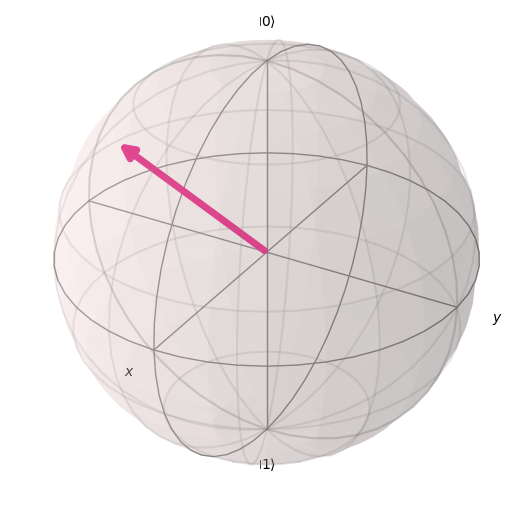

In [2]:
from qiskit.visualization import plot_bloch_vector

r = [rx, ry, rz]
plot_bloch_vector(r)

## 3. Quantum state tomography

If you just measure the quantum state in the computational basis ($|0 \rangle$ and  $|1 \rangle$), the phase information (the complex number information) will be lost. But if we have many copies of $|\psi \rangle$ by repeating the preparation process (we can't clone states, but we can repeat preparation processes), we can estimate the value of $r_{x}, r_{y}, r_{z}$ by performing *quantum state tomography* for density matrix $\rho$. Given the form:

$$
\rho = \frac{1}{2}(\textbf{I} + r_{x}\textbf{X}+ r_{y}\textbf{Y} + r_{z}\textbf{Z})
$$

it holds that

$$
Tr(\textbf{X} \rho) =  r_{x}, \quad Tr(\textbf{Y} \rho) =  r_{y}, \quad Tr(\textbf{Z} \rho) =  r_{z}
$$

In $r_{z}$ case,

$$
Tr(\textbf{Z} \rho) =  \langle 0|\textbf{Z} \rho|0 \rangle +  \langle 1|\textbf{Z} \rho|1 \rangle
$$
$$
= \langle 0|(|0 \rangle\langle 0|-|1 \rangle\langle 1|) \rho|0 \rangle +\langle 1|(|0 \rangle\langle 0|-|1 \rangle\langle 1|) \rho|1 \rangle
$$
$$
=\langle 0|\rho|0 \rangle- \langle 1| \rho|1 \rangle
$$
$$
=\langle 0|\psi\rangle\langle \psi|0 \rangle -  \langle 1| \psi\rangle\langle \psi|1 \rangle
$$
$$
=|\alpha|^2-|\beta|^2
$$

The last transformation of the equation is for $|\psi \rangle  =\alpha|0\rangle+\beta|1\rangle$. Therefore, we can obtain $r_{z}$ by  Probability of $|0 \rangle$  - Probability of $|1 \rangle$.

### Estimate $r_z$ value

In order to estimate $r_z$, we create a quantum state and measure it. We then repeat the preparation and measurement many times. Finally we use the statistics of the measurement to estimate the probabilities above and thus estimate $r_z$.

For creating the random quantum state, we will use the general unitary gate $U$ with the parameters; $ \theta, \varphi$. (Please refer to [U-gate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.UGate.html) for more information.)

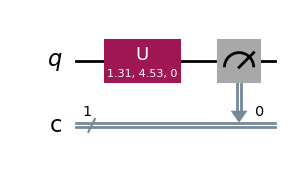

In [3]:
from qiskit import QuantumCircuit

# create a 1-qubit quantum state psi from theta, varphi parameters
qc = QuantumCircuit(1, 1)
qc.u(theta, varphi, 0.0, 0)

# measure in computational basis
qc.measure(0, 0)

qc.draw(output="mpl")

Using the `AerSimulator`, we will measure it in the computational basis to estimate $r_z$.

{'1': 375, '0': 625}


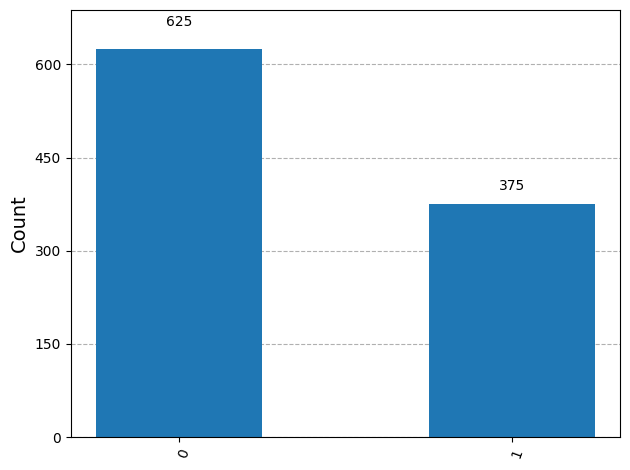

In [4]:
# see if the expected value of measuring in the computational basis
# approaches the limit of rz
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Sampler
from qiskit.visualization import plot_histogram

# Define backend
backend = AerSimulator()
nshots = 1000  # or 10000
# nshots = 10000

# Transpile to backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(qc)

# Run the job
sampler = Sampler(mode=backend)
job = sampler.run([isa_qc], shots=nshots)
result = job.result()

# Extract counts data
counts = result[0].data.c.get_counts()
print(counts)

# Plot the counts in a histogram

plot_histogram(counts)

In [5]:
rz_approx = (counts["0"] - counts["1"]) / nshots

print("rz = ", rz, " and approx of rz = ", rz_approx)

rz =  0.2577405946274022  and approx of rz =  0.25


Using the quantum state tomography method, we estimated the $r_z$ value. In this case, since we chose a parameter for the "random" state, we know the value of $r_z$ and can check our work. But by its very nature, utility-scale work is not always so trivial to check. We will discuss more about checking quantum results later in this course. For now, simply note that our estimation was reasonably accurate.

### Exercise 1: Estimate $r_x$ value
Recall that IBM quantum computers measure along the $z$-axis (sometimes stated "in the $z$ basis" or "in the computational basis"). However, by using rotations before the measurement, we can measure the quantum state's projection on the x-axis, also. To be more precise, if we rotate our system such that things that did point along $x$ now point along $z$, then we can keep the same measurement hardware along $z$, but learn about the state that was just along $x$ a moment ago. This is how most quantum computers (and all IBM quantum comptuers) perform measurements along multiple axes.

With this understanding, try writing code to estimate the value of $r_x,$ using quantum state tomography.

__Solution__:

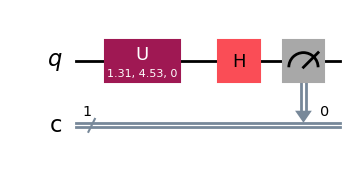

In [6]:
# create a 1-qubit quantum state psi from theta, varphi parameters
qc = QuantumCircuit(1, 1)
qc.u(theta, varphi, 0.0, 0)

qc.h(0)
qc.measure(0, 0)

qc.draw(output="mpl")

{'1': 5925, '0': 4075}


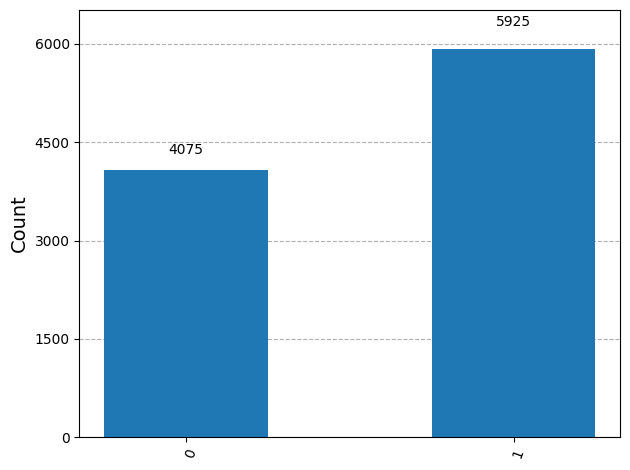

In [7]:
# Define backend
backend = AerSimulator()
nshots = 10000

# Transpile to backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(qc)

# Run the job
sampler = Sampler(mode=backend)
job = sampler.run([isa_qc], shots=nshots)
result = job.result()

# Extract counts data
counts = result[0].data.c.get_counts()
print(counts)

# Plot the counts in a histogram
plot_histogram(counts)

In [8]:
rx_approx = (counts["0"] - counts["1"]) / nshots

print("rx = ", rx, " and approx of rx = ", rx_approx)

rx =  -0.1791150283307452  and approx of rx =  -0.185


### Exercise 2: Estimate $r_y$ value
Using the same logical arguments as before, we can rotate the system prior to measurement to learn about the $r_y$.
Try writing code yourself to estimate the value of $r_y$ using the quantum state tomography. You could start with the previous example, but make different rotations. (For more information about the various gates used, including ```sdg``` please refer [this](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#sdg).)

__Solution__:

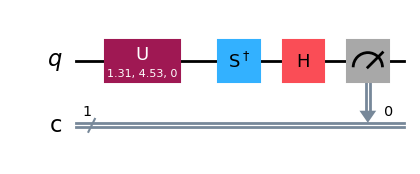

In [9]:
# create a 1-qubit quantum state psi from theta, varphi parameters
qc = QuantumCircuit(1, 1)
qc.u(theta, varphi, 0.0, 0)

qc.sdg(0)
qc.h(0)
qc.measure(0, 0)

qc.draw(output="mpl")

{'1': 9759, '0': 241}


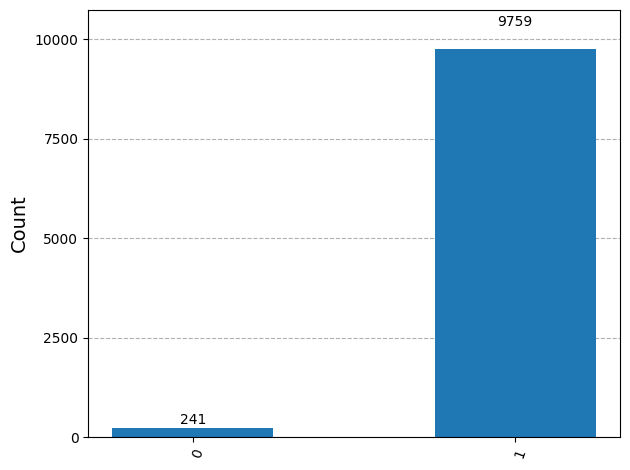

In [10]:
# Define backend
backend = AerSimulator()
nshots = 10000

# Transpile to backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(qc)

# Run the job
sampler = Sampler(mode=backend)
job = sampler.run([isa_qc], shots=nshots)
result = job.result()

# Extract counts data
counts = result[0].data.c.get_counts()
print(counts)

# Plot the counts in a histogram
plot_histogram(counts)

In [11]:
ry_approx = (counts["0"] - counts["1"]) / nshots

print("ry = ", ry, " and approx of ry = ", ry_approx)

ry =  -0.9494670044331133  and approx of ry =  -0.9518


We have now estimated all components of $\vec{r}$ and can write out the full vector.

In [12]:
print("Estimated vector is (", rx_approx, ",", ry_approx, ",", rz_approx, ").")
print("Original random vector was (" + str(rx) + ", " + str(ry) + ", " + str(rz) + ").")

Estimated vector is ( -0.185 , -0.9518 , 0.25 ).
Original random vector was (-0.1791150283307452, -0.9494670044331133, 0.2577405946274022).


You obtained the estimation of the original random vector fairly accurately using this quantum sate tomography method.

## 4. Quantum teleportation

Let us consider the situation when a character Alice wants to send an unknown quantum state $|\psi \rangle$ to her friend Bob, who is far away. Assume they can only communicate with classical communication (like using email or a phone). Alice cannot copy the quantum state (due to the no-cloning theorem). If she repeated the same preparation process many times, she could build up statistics as we just did. But what if there is only a single unknown state? This state might have emerged from a physical process you want to study. Or it could be part of a larger quantum computation. In that case, how could Alice send the state to Bob? She can, if she and Bob share a valuable quantum resource: a shared entangled state, like the Bell state introduced in the previous lesson: $\frac {|00\rangle + |11\rangle}{\sqrt 2}.$ You may sometimes also see this referred to as an "EPR pair" or an "e-bit" (a fundamental unit of entanglement). If Alice shares such an entangled state with Bob, she can *teleport* the unknown quantum state to Bob by performing a series of quantum operations and sending him two bits of classical information.

### 4.1 The protocol of Quantum teleportation
**Assumption**: Alice has an unknown quantum state $|\psi \rangle$ to be sent to Bob. Alice and Bob shares a 2-qubit entangled state, or e-bit, each having one of the qubits physically at their location.

Here we outline the procedure without explanation. These will be implemented in detail below.
1. Alice entangles $|\psi \rangle$  with her part of the e-bit using the CNOT gate.
2. Alice applies a Hadamard gate to $|\psi \rangle$, and measures both her qubits in the computational basis.
3. Alice sends Bob her measurement results (either “00”, “01”, “10”, or “11”)
4. Bob performs a *correction* operator based on Alice’s 2-bit of information on his part of the e-bit pair.
    - If “00”, Bob does nothing
    - If “01”, Bob applies X gate
    - If “10”, Bob applies Z gate
    - If “11”, Bob applies iY = ZX gate
5. Bob's part of the e-bit becomes $|\psi \rangle$.

This is also worked out in more detail in [Basics of Quantum Information](https://learning.quantum.ibm.com/course/basics-of-quantum-information/entanglement-in-action#teleportation). But the situation will become more clear as we instantiate this in Qiskit.

### 4.2 Quantum circuit simulating the quantum teleportation

As always, we will apply the Qiskit patterns framework. This subsection will focus on mapping only.

### Step 1: Map problem to quantum circuits and operators

To describe the scenario above, we need a circuit with three qubits: two for the entangled pair shared by Alice and Bob, and one for the unknown quantum state $|\psi\rangle$.

In [56]:
from qiskit import QuantumCircuit
import numpy as np

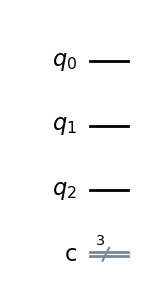

In [14]:
# create 3-qubits circuit
qc = QuantumCircuit(3, 3)

qc.draw(output="mpl")

At the start, Alice has an unknown quantum state $|\psi \rangle.$ We will create this using the $U$ gate.

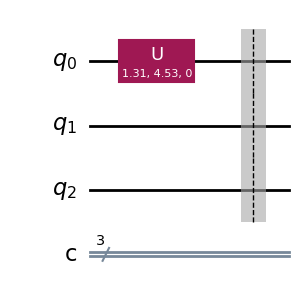

In [15]:
# Create the unknown quantum state using the u-gate. Alice has this.
qc.u(theta, varphi, 0.0, 0)
qc.barrier()  # for visual separation

qc.draw(output="mpl")

We can visualize the state we've created, but only because we know what parameters were used in the $U$ gate. If this state had emerged from a complicated quantum process, the state would not be knowable without running the process to create the state many times, and collecting statistics as in tomography.

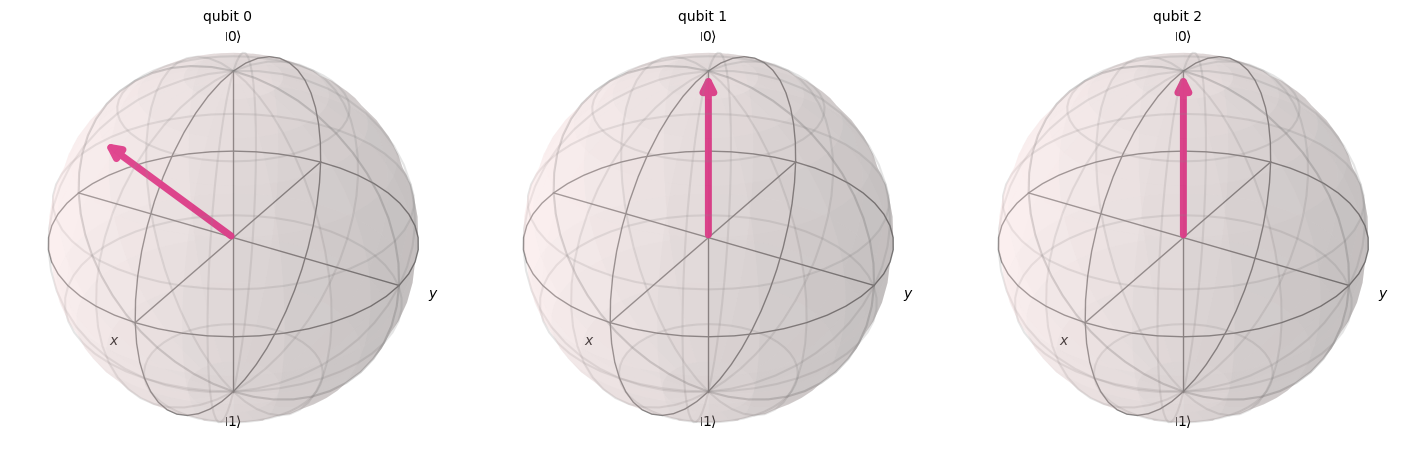

In [16]:
# show the quantum state on bloch sphere
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

out_vector = Statevector(qc)


plot_bloch_multivector(out_vector)

Before this protocol even begins, we assume Alice and Bob have a shared entangled pair. If Alice and Bob are truly in different locations, they might have set up the shared state *before* the unknown state $|\psi\rangle$ was ever created. Because those things are happening on different qubits, there order here won't matter, and this order is convenient for visualization.

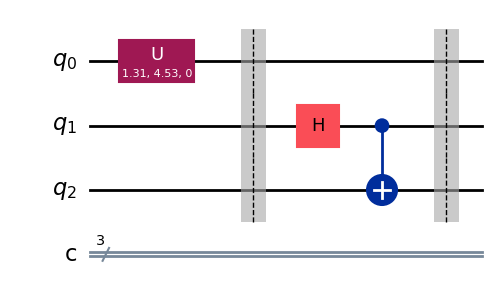

In [17]:
# Alice and Bob are together in the same place and set up an entangled pair.
qc.h(1)
qc.cx(1, 2)
qc.barrier()  # for visual separation.
# We can consider that Alice and Bob may move their qubits to different physical locations, now.

qc.draw(output="mpl")

Next, Alice entangles $|\psi \rangle$ with her part of the shared e-bit, using the $CX$ gate & $H$ gate, and measures them in the computational basis.

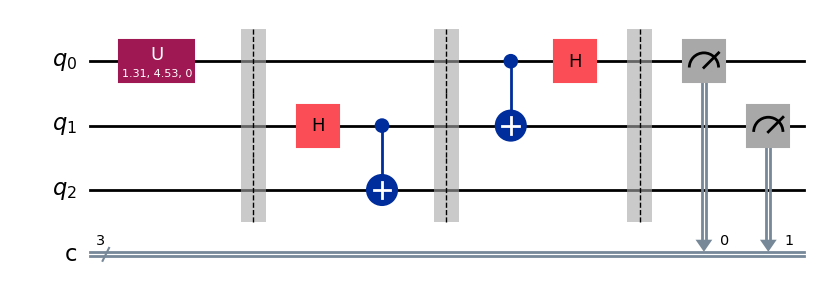

In [18]:
# Alice entangles the unknown state with her part of the e-bit, using the CNOT gate & H gate.
qc.cx(0, 1)
qc.h(0)
qc.barrier()

# Alice measures the two qubits.
qc.measure(0, 0)
qc.measure(1, 1)

qc.draw(output="mpl")

Alice sends Bob her measurement results (either “00”, “01”, “10”, or “11”), and Bob performs a correction operator based on Alice’s 2 bits of information on his part of the shared e-bit. Then, Bob's becomes $|\psi \rangle$.

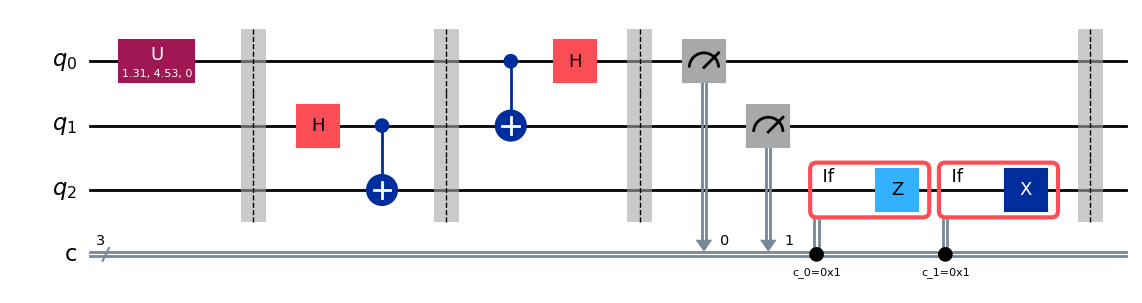

In [19]:
# Alice sent the results to Bob. Bob applies correction
with qc.if_test((0, 1)):
    qc.z(2)
with qc.if_test((1, 1)):
    qc.x(2)
qc.barrier()

qc.draw(output="mpl")

You have completed a quantum teleportation circuit! Let's see the output state of this circuit using the statevector simulator.

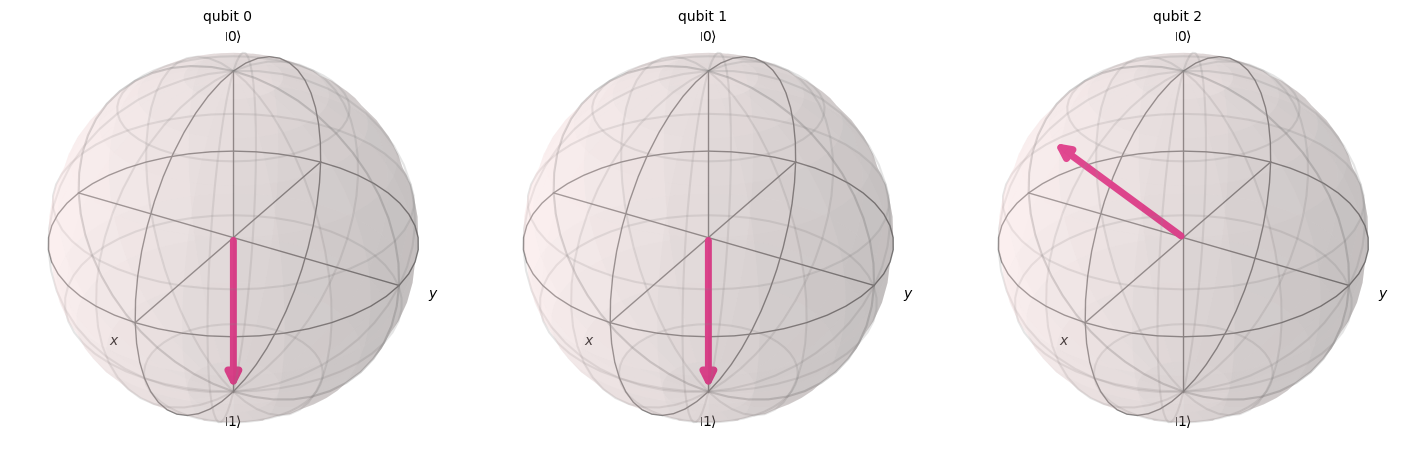

In [20]:
from qiskit_aer import StatevectorSimulator

backend = StatevectorSimulator()
out_vector = backend.run(qc, shots=1).result().get_statevector()  # set shots = 1

plot_bloch_multivector(out_vector)

You can see that the quantum state created by the $U$-gate of qubit 0 (the qubit originally holding the secret state) has been transferred to qubit 2 (Bob's qubit).

You can run above cell a few times to make sure. You may notice that the qubits 0 & 1 change states, but qubit 2 is always in the state $|\psi\rangle $.

### 4.3 Execute it and confirm the result by applying U inverse.

Above, we checked visually that the teleported state looked correct. Another way to check if the quantum state has been teleported correctly, is to apply the inverse of the $U$ gate on Bob's qubit so that we can measure '0'. That is, since $U^{-1}U$ is the identity, if Bob's qubit is in the state created from $U|0\rangle,$ then applying the inverse should yield $U^{-1}U|0\rangle=|0\rangle.$

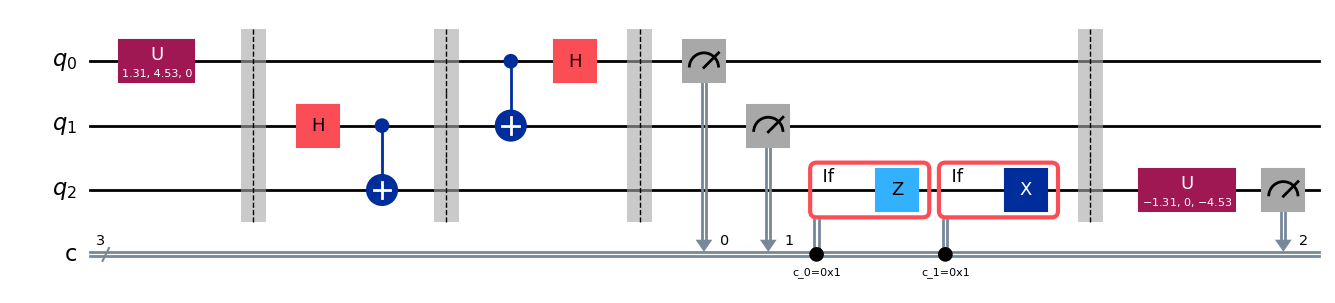

In [21]:
# Apply the inverse of u-gate to measure |0>
qc.u(theta, varphi, 0.0, 2).inverse()  # inverse of u(theta,varphi,0.0)
qc.measure(2, 2)  # add measurement gate

qc.draw(output="mpl")

We will execute the circuit first using the AerSimulator, before moving on to a real quantum comptuer.

{'011': 2510, '010': 2417, '000': 2635, '001': 2438}


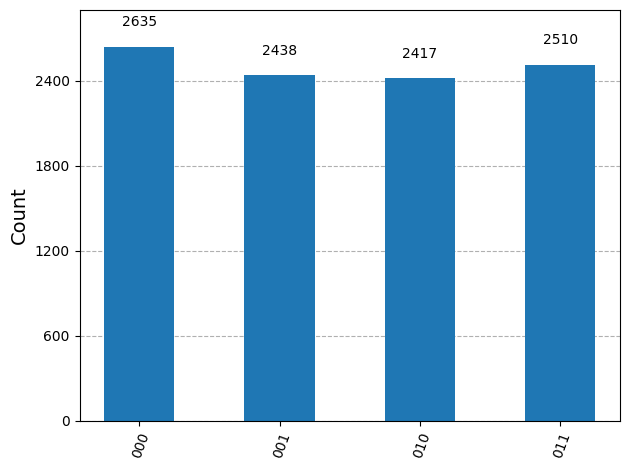

In [22]:
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Sampler
from qiskit.visualization import plot_histogram

# Define backend
backend = AerSimulator()

# Transpile to backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(qc)

# Run the job
sampler = Sampler(mode=backend)
job = sampler.run([isa_qc], shots=nshots)
result = job.result()

# Extract counts data
counts = result[0].data.c.get_counts()
print(counts)

# Plot the counts in a histogram
plot_histogram(counts)

Recall that in little endian notation, qubit 2 is the left-most (or bottom-most, in the column labels) qubit. Note that the left/bottom-most qubit in the column labels is a 0 for all possible outcomes. This shows we have a 100% chance of measuring $q_2$ in the state $|0\rangle $. This is the expected result, and indicates the teleportation protocol has worked properly.

### 4.4 Teleportation on a real quantum computer


Next, we will perform teleportation on a real quantum computer. Using the dynamic circuit function, we can operate mid-circuit using measurement outcomes, implementing in real-time the conditionals operations in the teleportation circuit. For solving problems with real quantum computers, we will follow the 4 steps of Qiskit Patterns.

    1. Map problem to quantum circuits and operators
    2. Optimize for target hardware
    3. Execute on target hardware
    4. Post-process the results

### Exercise 3: Build the teleportation circuit

Try building the whole teleportation circuit from scratch to test your understanding. Scroll back up if you need a reminder.

__Solution__:

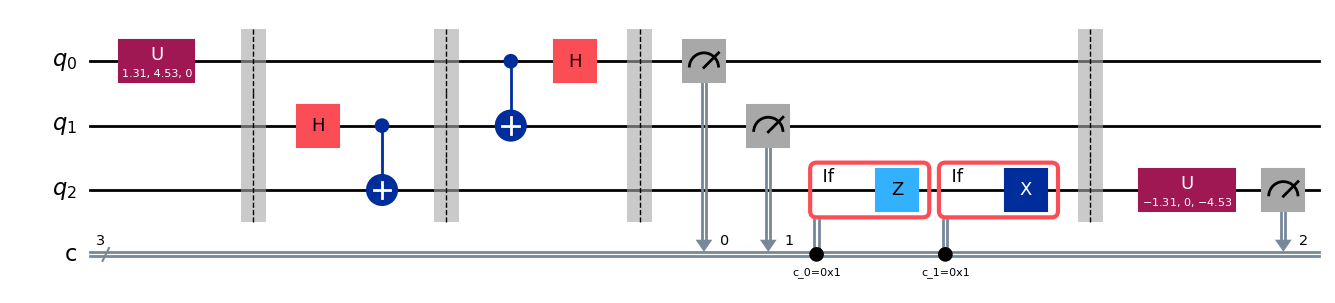

In [23]:
# Step 1: Map problem to quantum circuits and operators
# Create the circuit with 3-qubits and 1-bit
qc = QuantumCircuit(3, 3)

# Alice creates an unknown quantum state using the u-gate.
qc.u(theta, varphi, 0.0, 0)
qc.barrier()  # for visual separation

# Eve creates EPR pair and sends q1 to Alice and q2 to Bob
##your code goes here##
qc.h(1)
qc.cx(1, 2)
qc.barrier()

# Alice entangles the unknown state with her EPR part, using the CNOT gate & H gate.
##your code goes here##
qc.cx(0, 1)
qc.h(0)
qc.barrier()

# Alice measures the two qubits.
##your code goes here##
qc.measure(0, 0)
qc.measure(1, 1)

# Alice sent the results to Bob. Now, Bob applies correction
##your code goes here##
with qc.if_test((0, 1)):
    qc.z(2)
with qc.if_test((1, 1)):
    qc.x(2)
qc.barrier()

# Apply the inverse of u-gate to measure |0>
qc.u(theta, varphi, 0.0, 2).inverse()
qc.measure(2, 2)

qc.draw(output="mpl")

As a reminder, applying the inverse of the $U$ gate is just so we can verify the expected behavior. It isn't part of sending the state to Bob, and we would not use that inverse $U$ gate if the only goal was to transfer quantum information.

### Step 2: Optimize for target hardware

To run on hardware, import `QiskitRuntimeService` and load the saved credential for IBM quantum channel. And, select the backend with the fewest number of jobs in the queue.

In [25]:
from qiskit_ibm_runtime import QiskitRuntimeService

# If this is your first time running your circuit on a real device,
# make sure you copy your API Token from [IBM Quantum Platform](https://quantum.ibm.com/)
# QiskitRuntimeService.save_account(token='<your_token>', overwrite=True)

service = QiskitRuntimeService(channel="ibm_cloud")
service.backends()

/var/folders/hy/vlb64bx10q58zgckfl9r417m0000gn/T/ipykernel_17259/1134097524.py:7: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(channel="ibm_quantum")


[<IBMBackend('ibm_aachen')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_brussels')>,
 <IBMBackend('ibm_fez')>,
 <IBMBackend('ibm_kingston')>,
 <IBMBackend('ibm_marrakesh')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('ibm_strasbourg')>,
 <IBMBackend('ibm_torino')>]

In [26]:
# You can also identify the least busy device
backend = service.least_busy(operational=True)
print("The least busy device is ", backend)

The least busy device is  <IBMBackend('ibm_strasbourg')>


In [27]:
# You can specifiy the device
# backend = service.backend('ibm_sherbrooke')

Let's see the coupling map of the device which you selected.

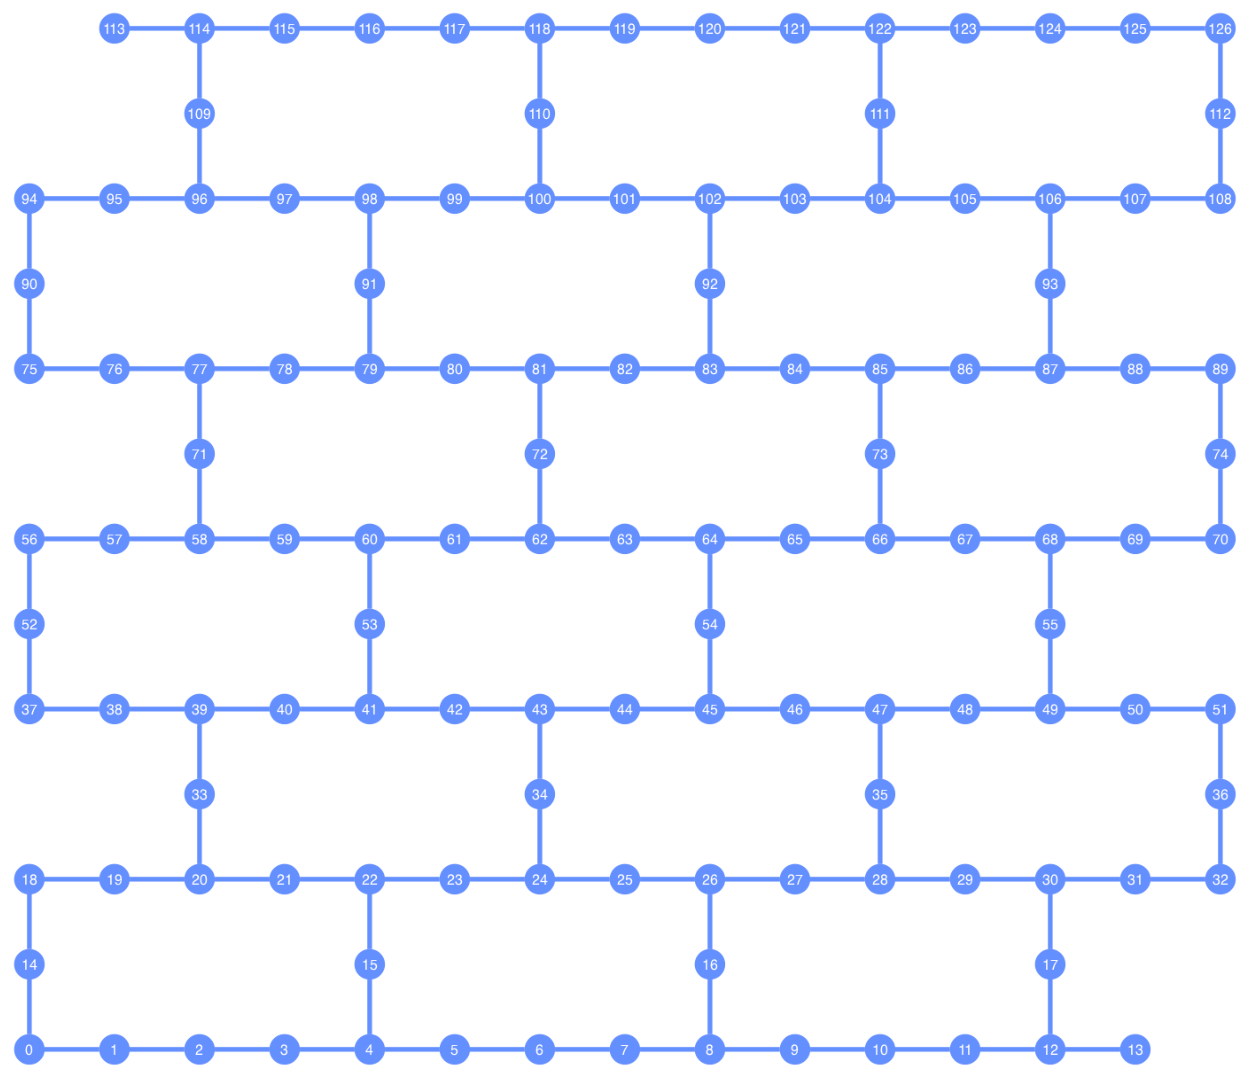

In [27]:
from qiskit.visualization import plot_gate_map

plot_gate_map(backend)

Different devices may have different coupling maps. And each device has some qubits and couplers that are more performant than others. Finally, different quantum computers may have different *native gates* (gates the hardware can execute). Transpiling the circuit rewrites the abstract quantum circuit using gates the target quantum computer can execute, and selects the optimal mapping to physical qubits (among other things). Transpilation is a rich and complicated topic. For more on transpilation, see this [documentation](https://docs.quantum.ibm.com/api/qiskit/transpiler#overview).

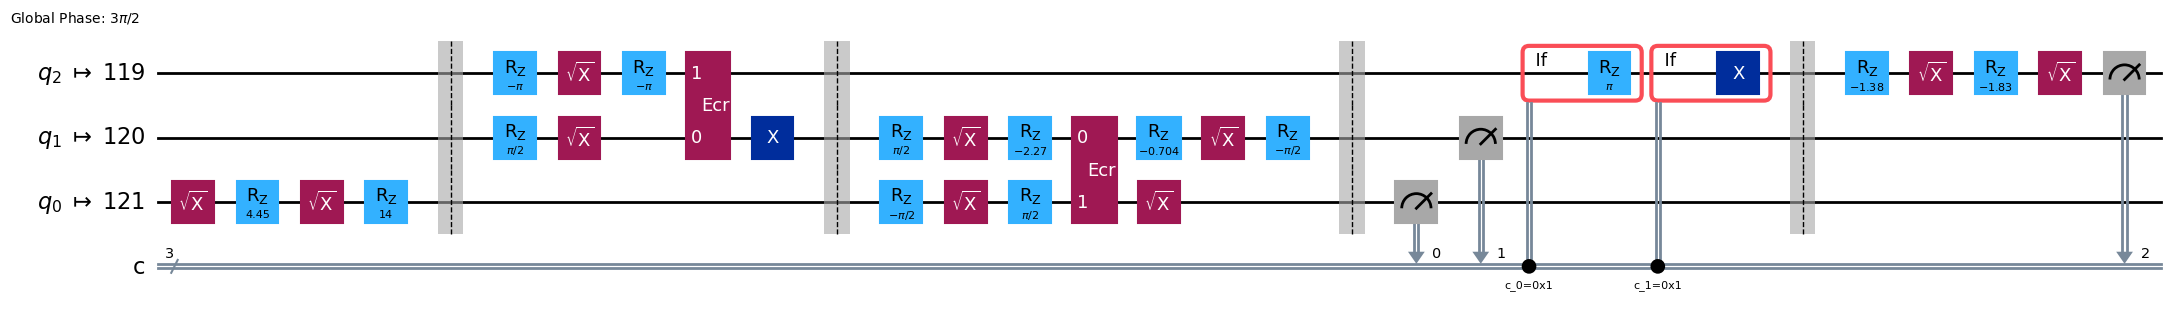

In [29]:
# Step 2: Optimize for target hardware
# Transpile the circuit into basis gates executable on the hardware
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
qc_compiled = pm.run(qc)

qc_compiled.draw("mpl", idle_wires=False, fold=-1)

### Step 3: Executing the circuit.

Using the `Sampler` runtime primitive, we will execute the target circuit.

In [30]:
# Step 3: Execute the target circuit
sampler = Sampler(backend)
job = sampler.run([qc_compiled])
job_id = job.job_id()
print("job id:", job_id)

job id: d13nkhpn2txg008jt0d0


/opt/homebrew/Caskroom/miniforge/base/envs/doc/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


In [32]:
# Check the job status
job.status()

'DONE'

You can also check the job status from your IBM Quantum Dashboard：https://quantum.cloud.ibm.com/workloads

In [36]:
# If the Notebook session got disconnected you can also check your job statuse by running the following code
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_cloud")
job_real = service.job(job.job_id())  # Input your job-id between the quotations
job_real.status()

/var/folders/hy/vlb64bx10q58zgckfl9r417m0000gn/T/ipykernel_17259/2820024773.py:3: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(channel="ibm_quantum")


'DONE'

If you see `'DONE'` is displayed, you can get the result by executing below cell.

In [37]:
# Execute after 'DONE' is displayed
result_real = job_real.result()
print(result_real[0].data.c.get_counts())

{'001': 992, '110': 430, '011': 579, '010': 605, '111': 402, '000': 925, '100': 57, '101': 106}


### Step 4: Post-process the results

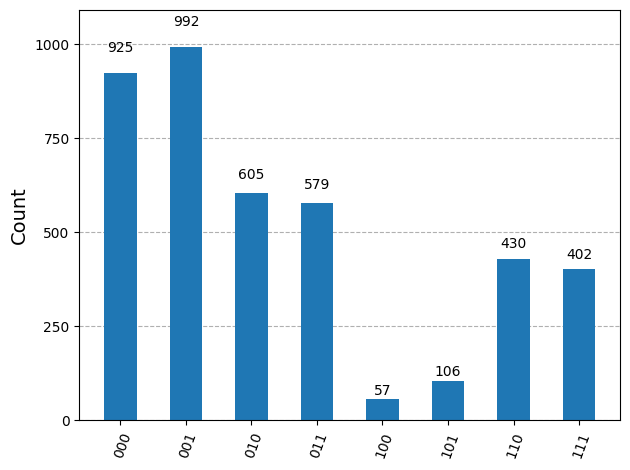

In [38]:
# Step 4: Post-process the results
from qiskit.visualization import plot_histogram

plot_histogram(result_real[0].data.c.get_counts())

You can interpret the results above directly. Or, using `marginal_count`, you can trace out Bob's results on qubit 2.

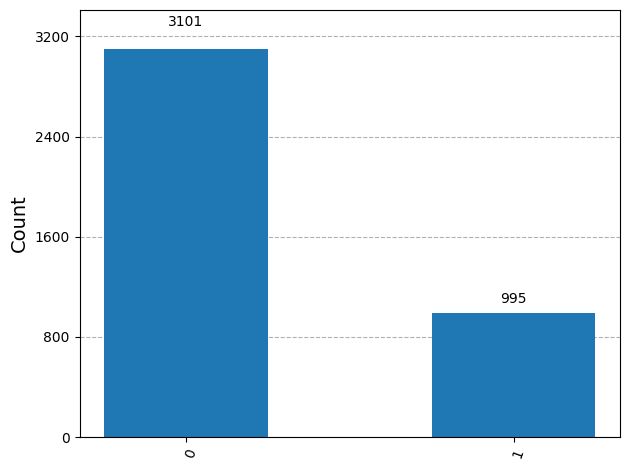

In [39]:
# trace out Bob's results on qubit 2
from qiskit.result import marginal_counts

bobs_qubit = 2
real_counts = result_real[0].data.c.get_counts()
bobs_counts = marginal_counts(real_counts, [bobs_qubit])
plot_histogram(bobs_counts)

As we see here, there are a few results in which we measured $|1 \rangle$. These are due to noise and errors. In particular, Dynamic Circuits tend to have a higher error rate because of the time-consuming measurement in the middle of the circuit.

### 4.5 Key takeaways on quantum teleportation

We can transport a quantum state to a distant friend by sharing a pair of entangled qubits (an e-bit).

1. Can quantum teleportation send the quantum state faster than light?
	No. Because Alice has to tell Bob the measurement results in a classical way.

2. Would quantum teleportation break the "no cloning theorem", which forbids copying of a quantum state?
	No. Because the original quantum state given to Alice on one of her qubits was lost in measurement. It collapsed to a $|0\rangle$ or $|1\rangle$.

## 5. Superdense coding

Almost the same setup can be used for a different purpose. Suppose Alice wants to send Bob two bits of classical information, but she has no means of classical communication with Bob. She does, however, share an entangled pair with Bob and she is allowed to send her qubit to Bob's location. Notice the contrast with the quantum teleportation protocol. In teleportation, classical communication _was_ available to the friends, and the goal was to send a quantum state. Here, classical communication is not accessible and they use the transfer of a qubit to share 2 bits of classical information.

### 5.1 The protocol of superdense coding

**Assumption**: Alice has 2 bits of information, say, $a_1a_2 \in \{00, 01, 10, 11\}$. Alice and Bob share an entangled pair (e-bit), but they cannot communicate classically.

1. Alice performs one of the following operations on her part of e-bit.
    - If $a_1a_2 = 00$, she does nothing
    - If $a_1a_2 = 01$, she applies Z gate
    - If $a_1a_2 = 10$, she applies X gate
    - If $a_1a_2 = 11$, she applies Z gate and X gate.
2. Alice sends her part of the e-bit to Bob's location.
3. Bob applies a CNOT gate with the qubit from Alice as control and his qubit as target, then applies H gate to the qubit from Alice, and measures the two qubits. The possible starting states and results of Bob's operations are:
$$
\frac {|00\rangle + |11\rangle}{\sqrt 2} \rightarrow CX_{01}\otimes H_0 \rightarrow |00\rangle
$$
$$
\frac {|00\rangle - |11\rangle}{\sqrt 2} \rightarrow CX_{01}\otimes H_0 \rightarrow |01\rangle
$$
$$
\frac {|10\rangle + |01\rangle}{\sqrt 2} \rightarrow CX_{01}\otimes H_0 \rightarrow |10\rangle
$$
$$
\frac {|10\rangle - |01\rangle}{\sqrt 2} \rightarrow CX_{01}\otimes H_0 \rightarrow -|11\rangle
$$

Please note that a negative sign of $-|11\rangle$ is global phase, so it is not measurable.

### 5.2 Quantum circuit simulating the superdense coding

Based on the protocol of superdense coding, you can build the superdense coding circuit as below. Please try to change the message, `msg`, which Alice wants to transform to Bob.

In [40]:
from qiskit import QuantumCircuit

Qiskit pattern steps are identified in the code comments.

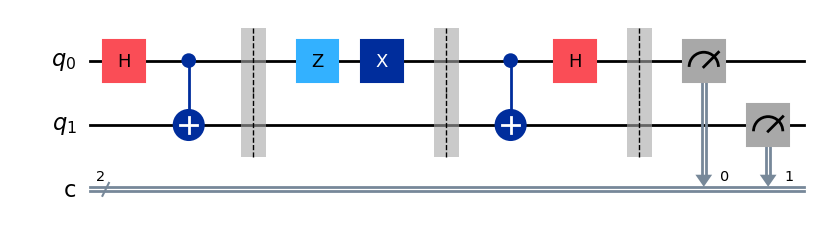

In [41]:
# Step 1: Map problem to quantum circuits and operators
# Create 2-qubits circuit
qc = QuantumCircuit(2, 2)

# Eve creates EPR pair and send q0 to Alice and q1 to Bob
qc.h(0)
qc.cx(0, 1)
qc.barrier()

# set message which Alice wants to transform to Bob
msg = "11"  # You can change the message

if msg == "00":
    pass
elif msg == "10":
    qc.x(0)
elif msg == "01":
    qc.z(0)
elif msg == "11":
    qc.z(0)
    qc.x(0)

qc.barrier()
# Bob receives EPR qubit from Alice and performs unitery operations
qc.cx(0, 1)
qc.h(0)
qc.barrier()

# Bob measures q0 and q1
qc.measure(0, 0)
qc.measure(1, 1)

qc.draw(output="mpl")

In [42]:
# We will execute on a simulator first
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Sampler

# Define backend
backend = AerSimulator()
shots = 1000

# Transpile to backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(qc)

# Run the job
sampler = Sampler(mode=backend)
job_sim = sampler.run([isa_qc], shots=shots)
result_sim = job_sim.result()

# Extract counts data
counts = result_sim[0].data.c.get_counts()
print(counts)

{'11': 1000}


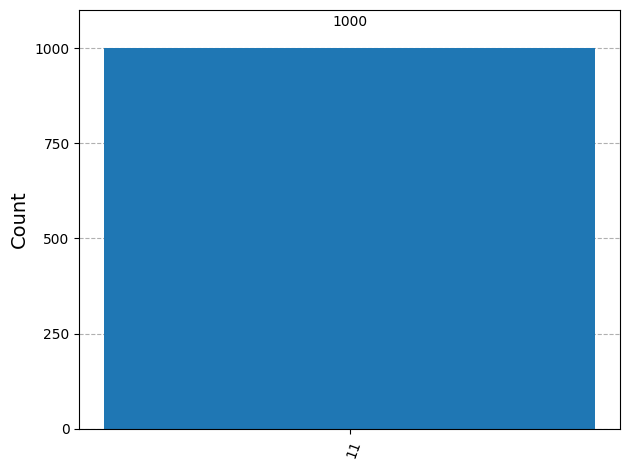

In [43]:
# Visualize the results
from qiskit.visualization import plot_histogram

plot_histogram(counts)

You can see that Bob received the message which Alice wanted to send to him.

Next, let's try it with a real quantum computer.

In [51]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True)
print("The least busy device is ", backend)

/var/folders/hy/vlb64bx10q58zgckfl9r417m0000gn/T/ipykernel_17259/1906159288.py:2: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(channel="ibm_quantum")


The least busy device is  <IBMBackend('ibm_strasbourg')>


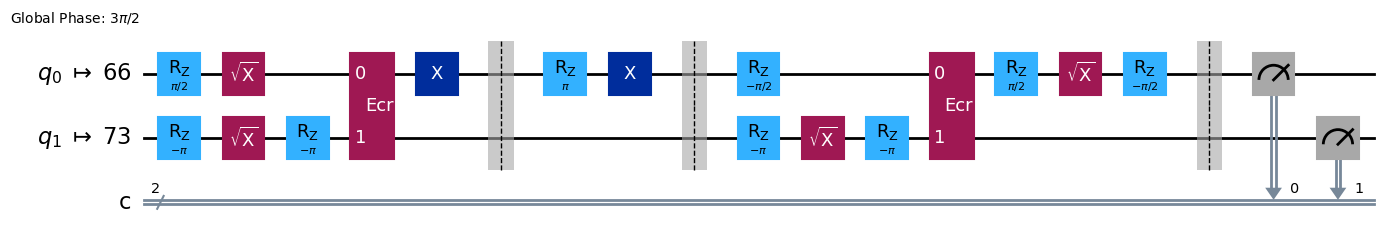

In [45]:
# Step 1 was already completed before the simulator job above.
# Step 2: Optimize for target hardware
# Transpile the circuit into basis gates executable on the hardware
pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
qc_compiled = pm.run(qc)

qc_compiled.draw("mpl", idle_wires=False)

In [46]:
# Step 3:Execute the target circuit
sampler = Sampler(backend)
job = sampler.run([qc_compiled])
job_id = job.job_id()
print("job id:", job_id)

job id: d13nnyq3grvg008j0zag


/opt/homebrew/Caskroom/miniforge/base/envs/doc/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


In [49]:
# Check the job status
job.status()

'DONE'

In [52]:
# If the Notebook session got disconnected you can also check your job statuse by running the following code
# from qiskit_ibm_runtime import QiskitRuntimeService
# service = QiskitRuntimeService(channel="ibm_quantum")
job = service.job(job_id)  # Input your job-id between the quotations
job.status()

'DONE'

In [53]:
# Execute after job has successfully run
real_result = job.result()
print(real_result[0].data.c.get_counts())

{'11': 3942, '01': 107, '10': 41, '00': 6}


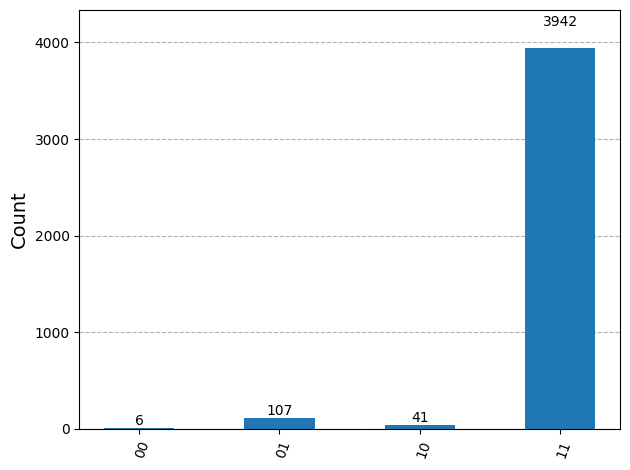

In [54]:
# Step 4: Postprocess the results
from qiskit.visualization import plot_histogram

plot_histogram(real_result[0].data.c.get_counts())

The result is what we expected. Note that superdense coding on a real quantum computer showed fewer errors than in the case of quantum teleportation on a real quantum computer. One reason for this may be that quantum teleportation uses dynamic circuits and superdense coding does not. We will learn more about errors in quantum circuits in later lessons.

## 7. Summary

In this session, we have implemented two quantum protocols. Although the scenarios for both involving distant friends are somewhat removed from quantum computing on a single QPU, they have applications in quantum computing, and help us understand the transfer of quantum information better.

- **Quantum teleportation**: Although we cannot copy quantum states, we can teleport unknown quantum state by having shared entanglement.
- **Quantum superdense coding**: A shared entangled pair, and transfer of 1 qubit enable the communication of 2 bits of classical information.

In [55]:
# See the version of Qiskit
import qiskit

qiskit.__version__

'2.0.2'